# **Training Set**

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)
from google.colab import drive

from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os


In [2]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/'
train_dir = '/content/drive/MyDrive/dataset/chest_xray/train'
test_dir = '/content/drive/MyDrive/dataset/chest_xray/test'
val_dir = '/content/drive/MyDrive/dataset/chest_xray/val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 180
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) #qui c
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data(train_dir)
val = get_training_data(val_dir)

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-3-d8480ec656c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [5]:
print(train.shape)
print(val.shape)


(5216, 2)
(16, 2)


Unbalanced so we must balance with class_weight

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


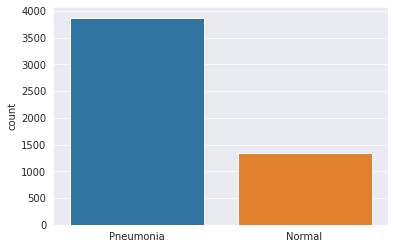

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

Create  array 

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []



for feature, label in train:
    x_train.append(feature)
    y_train.append(label)


    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)






Text(0.5, 1.0, 'NORMAL')

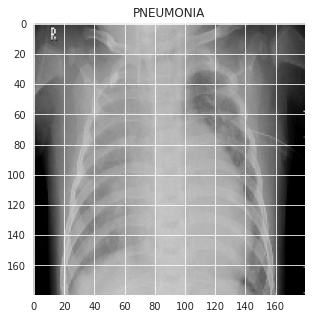

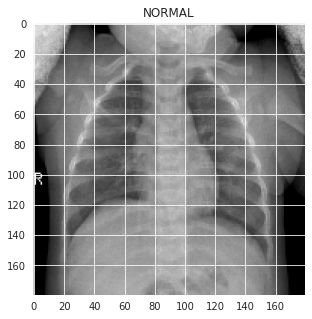

In [8]:
plt.figure(figsize = (5,5))
# plt.imshow(train[0][0], cmap='gray')
plt.imshow(train[0][0])

plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [9]:
x_train = np.array(x_train)/255 
x_val = np.array(x_val)/255 

print(x_train.shape)
print(x_val.shape)





(5216, 180, 180, 3)
(16, 180, 180, 3)


In [10]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)




In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(y_train),
                                                  y = y_train)

# the field class weight in model.fit() is a dictionary, so we convert class_weights into a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [12]:
#is maded the one hot encoding to train the keras model
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)

print(y_train.shape)
print(y_val.shape)

(5216, 2)
(16, 2)


# **CNN ALEXNET** --> overfitted

### **Train**

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
model = keras.models.Sequential()
#1st Convolutional Layer
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [img_size, img_size,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#2nd Convolutional Layer
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#3rd Convolutional Layer
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#4th Convolutional Layer
model.add(keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#Passing it to a Fully Connected layer
model.add(keras.layers.Flatten())

# 1st Fully Connected Layer
model.add(keras.layers.Dense(64,activation='relu'))

# 2st Fully Connected Layer
model.add(keras.layers.Dense(64,activation='relu'))

#Softmax layer for output
model.add(keras.layers.Dense(2,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_15 (Bat  (None, 87, 87, 64)      

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(aug.flow(x_train, y_train, batch_size=32), epochs=20, validation_data=(x_val, y_val) , verbose = 1 , callbacks=[early_stopping], class_weight = class_weights)

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 7.3923 - accuracy: 0.6258

163/163 [==============================] - 586s 4s/step - loss: 7.3923 - accuracy: 0.6258 - val_loss: 118.1962 - val_accuracy: 0.5000
Epoch 2/20
 18/163 [==>...........................] - ETA: 9:19 - loss: 2.5272 - accuracy: 0.6962

KeyboardInterrupt: ignored

### **Test**

In [ ]:
model.save('/content/drive/MyDrive/model/Alex.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# del(x_train)
# del(y_train)
# del(train)
# del(x_val)
# del(y_val)
# del(val)


# we load here to not overload the memory
test = get_training_data(test_dir)
print(test.shape)
x_test = []
y_test = []
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

x_test = np.array(x_test)/255 
print(x_test.shape)
x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [ ]:
# pred = model.predict_classes(x_test)
predict_x=model.predict(x_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test, pred)*100)

In [ ]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

# **CNN MNIST** --> overfitted

### **Train**

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#we made the model with the augmentation layer

model = keras.models.Sequential()
# 1 layer
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [img_size, img_size,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.15))
# 2 layer
model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.15))
# 3 layer
model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.15))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(2,activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 87, 87, 64)      

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(aug.flow(x_train, y_train, batch_size=32), epochs=15, validation_data=(x_val, y_val) , verbose = 1 , callbacks=[early_stopping], class_weight = class_weights)

Epoch 1/15
163/163 [==============================] - 30s 112ms/step - loss: 4.9310 - accuracy: 0.7812 - val_loss: 21.7648 - val_accuracy: 0.5000
Epoch 2/15
163/163 [==============================] - 14s 87ms/step - loss: 3.4579 - accuracy: 0.8516 - val_loss: 19.6858 - val_accuracy: 0.5000
Epoch 3/15
163/163 [==============================] - 14s 88ms/step - loss: 3.3457 - accuracy: 0.8629 - val_loss: 43.7761 - val_accuracy: 0.5000
Epoch 4/15
163/163 [==============================] - 14s 88ms/step - loss: 2.6663 - accuracy: 0.8765 - val_loss: 62.8108 - val_accuracy: 0.5000
Epoch 5/15
163/163 [==============================] - 16s 96ms/step - loss: 2.6004 - accuracy: 0.8884 - val_loss: 7.2310 - val_accuracy: 0.6250
Epoch 6/15
163/163 [==============================] - 14s 88ms/step - loss: 2.5040 - accuracy: 0.8852 - val_loss: 6.7315 - val_accuracy: 0.4375
Epoch 7/15
163/163 [==============================] - 15s 89ms/step - loss: 2.3383 - accuracy: 0.8888 - val_loss: 56.5568 - val_acc

### **Test**

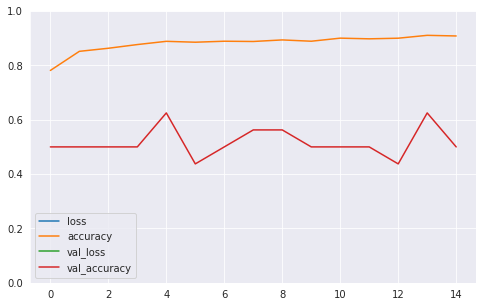

In [ ]:
model.save('/content/drive/MyDrive/model/Mnist.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# del(x_train)
# del(y_train)
# del(train)
# del(x_val)
# del(y_val)
# del(val)


# we load here to not overload the memory
test = get_training_data(test_dir)
print(test.shape)
x_test = []
y_test = []
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

x_test = np.array(x_test)/255 
print(x_test.shape)
x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion faile

<ipython-input-4-75955b58b4e0>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
# pred = model.predict_classes(x_test)
predict_x=model.predict(x_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test, pred)*100)

20/20 [==============================] - 1s 13ms/step
Test Data accuracy:  62.5


In [ ]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       390
           1       0.00      0.00      0.00       234

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Differenza tra Feature extraction e fine tuning](https://towardsdatascience.com/cnn-transfer-learning-fine-tuning-9f3e7c5806b2)

# **EfficientNet Feature extraction**

### **Train**

In [13]:
#Defining the model
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(img_size,img_size,3),classes=y_train.shape[1]) #input shape si puo specificare se include top è falso
#freezing all the layers
base_model.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers

model= Sequential()
model.add(base_model) 
#model.add(keras.layers.BatchNormalization())
model.add(Flatten()) 

#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 6, 6, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


Aggiungo pezzo per la classificazione

In [14]:
#Adding the Dense layers along with activation and batch normalization
# model.add(Dense(1024,activation=('relu'),input_dim=512))

# model.add(Dense(512,activation=('relu'))) 
# model.add(Dense(256,activation=('relu'))) 
# model.add(Dropout(.3))
model.add(Dense(64,activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(2,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 6, 6, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 512)               23593472  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27,644,069
Trainable params: 23,594,498
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
#Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

In [17]:
#Defining the parameters
batch_size= 64
epochs=20
# learn_rate=.001 ---> commentato perche uso quello di default
#early stopping quella di prima
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)
history = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(x_val, y_val) , verbose = 1 , callbacks=[early_stopping], class_weight = class_weights)

Epoch 1/20
82/82 [==============================] - 49s 429ms/step - loss: 26.5141 - accuracy: 0.3225 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/20
82/82 [==============================] - 33s 406ms/step - loss: 1.0126 - accuracy: 0.2699 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 3/20
82/82 [==============================] - 35s 424ms/step - loss: 0.6936 - accuracy: 0.2705 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
82/82 [==============================] - 33s 408ms/step - loss: 0.9922 - accuracy: 0.4653 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/20
82/82 [==============================] - 33s 404ms/step - loss: 0.6936 - accuracy: 0.5688 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
82/82 [==============================] - 33s 406ms/step - loss: 0.7702 - accuracy: 0.5412 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 7/20
82/82 [==============================] - 35s 423ms/step - loss: 0.6935 - accuracy: 0.2571 - val_loss: 0.6931 - val_accuracy: 0.500

### **Test**

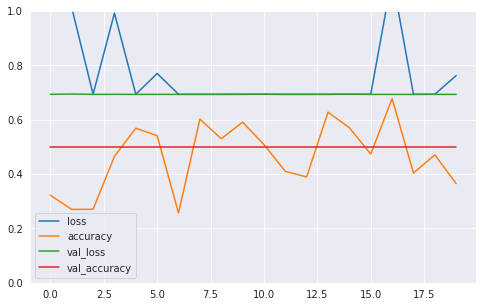

In [18]:
model.save('/content/drive/MyDrive/model/Efficentnet.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [19]:
# del(x_train)
# del(y_train)
# del(train)
# del(x_val)
# del(y_val)
# del(val)


# we load here to not overload the memory
test = get_training_data(test_dir)
print(test.shape)
x_test = []
y_test = []
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

x_test = np.array(x_test)/255 
print(x_test.shape)
x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

<ipython-input-3-d8480ec656c6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 2)
(624, 180, 180, 3)


In [20]:
# pred = model.predict_classes(x_test)
predict_x=model.predict(x_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test, pred)*100)

20/20 [==============================] - 4s 49ms/step
Test Data accuracy:  37.5


In [21]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       390
           1       0.38      1.00      0.55       234

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Disconnect from Colab (used for testing)

In [ ]:
from google.colab import runtime
runtime.unassign()